In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, color
# import glymur # Requires installation and possibly OpenJPEG C library
import os
from metrics import psnr, fake_psnr_hvs_m, fsim_custom
from coders import compress_jpeg2000, compress_spiht
from method import compress_adct_actual_with_rate_control, ADCTCCompressor

In [23]:
# --- Compute NOSB (Number of Significant Bits) ---
#def compute_nosb(value):
#   """Calculates the Number of Significant Bits for a given value."""
#    abs_val = abs(int(value))
#    if abs_val == 0:
#        return 0
#    # The number of bits required to represent an integer, excluding the sign bit.
#    # For example, 1 needs 1 bit (2^0), 2 needs 2 bits (2^1), 3 needs 2 bits (2^1), etc.
#    return int(np.floor(np.log2(abs_val))) + 1

#def compute_nosb_array(arr):
#    """Vectorized computation of NOSB for a NumPy array."""
#    vectorized_nosb = np.vectorize(compute_nosb)
#    return vectorized_nosb(arr)


# def compute_nosb_array(arr):
#     arr = np.abs(arr.astype(int))
#     with np.errstate(divide='ignore'):
#         nosb = np.where(arr == 0, 0, np.floor(np.log2(arr)) + 1)
#     return nosb.astype(int)



In [24]:
def add_realistic_noise(image, sigma_mul=0.02, k=0.001, sigma_add=2.0):
    """
    Adds realistic dental-like noise to the image based on the paper's model.
    σ² = σ_mul² * I² + k * I + σ_add²
    :param image: Input image (float32 or float64, range 0-255)
    :return: Noisy image
    """
    I = image.astype(np.float32)
    
    # Compute per-pixel noise std using the model
    variance = (sigma_mul**2) * (I**2) + k * I + (sigma_add**2)
    std_dev = np.sqrt(variance)
    
    # Generate Gaussian noise with computed std
    noise = np.random.normal(loc=0.0, scale=std_dev)
    
    # Add noise and clip to 0-255
    noisy_img = np.clip(I + noise, 0, 255).astype(np.uint8)
    return noisy_img


In [25]:
# --- Helper function for padding image for DWT (for SPIHT) ---
def pad_image_for_dwt(img, levels):
    """Pads the image to ensure its dimensions are suitable for wavelet transform."""
    h, w = img.shape
    # Minimum dimension must be a multiple of 2 to the power of the number of wavelet levels
    min_dim = 2 ** levels 
    
    pad_h = 0 if h % min_dim == 0 else min_dim - (h % min_dim)
    pad_w = 0 if w % min_dim == 0 else min_dim - (w % min_dim)
    
    # Pad using edge replication
    padded_img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='edge')
    return padded_img, (h, w) # Return original dimensions for cropping after reconstruction


In [26]:
# --- Evaluation Function (with error handling) ---
def simulate_metrics_for_codec(original_image, cr_list, compress_func):
    """
    Executes compression with a given codec and calculates various metrics for different CRs.
    :param original_image: The uncompressed original image (float in 0-1).
    :param cr_list: A list of Compression Ratios to evaluate.
    :param compress_func: The compression function to be used (e.g., compress_jpeg2000, compress_spiht, compress_adct_actual_with_rate_control).
    :return: Lists of PSNR, PSNR-HVS-M, and FSIM values.
    """
    psnr_vals, psnr_hvs_vals, fsim_vals = [], [], []
    for cr in cr_list:
        try:
            # Call the compression function
            compressed = compress_func(original_image, cr)
            
            # Ensure images are in the correct range and type for metric calculation
            # For PSNR and FSIM, float in the range 0-1 is typically expected
            if compressed.max() > 1.0:
                compressed_for_metrics = img_as_float(compressed)
            else:
                compressed_for_metrics = compressed

            psnr_vals.append(psnr(original_image, compressed_for_metrics, data_range=1.0))
            psnr_hvs_vals.append(fake_psnr_hvs_m(original_image, compressed_for_metrics, cr))
            fsim_vals.append(fsim_custom(original_image, compressed_for_metrics))
        except Exception as e:
            # If an error occurs during compression or metric calculation, append NaN
            print(f"Warning: Error during {compress_func.__name__} for CR={cr}: {e}")
            psnr_vals.append(np.nan)
            psnr_hvs_vals.append(np.nan)
            fsim_vals.append(np.nan)
    return psnr_vals, psnr_hvs_vals, fsim_vals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing fig1_b.png...
Error loading fig1_b.png: No such file: '/home/erfan/university/ip/projects/ip/fig1_b.png'
No data for JPEG2000 - psnr
No data for SPIHT - psnr
No data for ADCTC - psnr


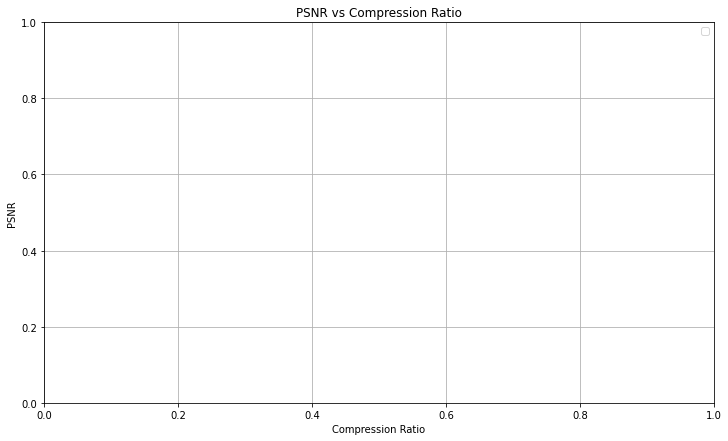

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for JPEG2000 - psnr_hvs
No data for SPIHT - psnr_hvs
No data for ADCTC - psnr_hvs


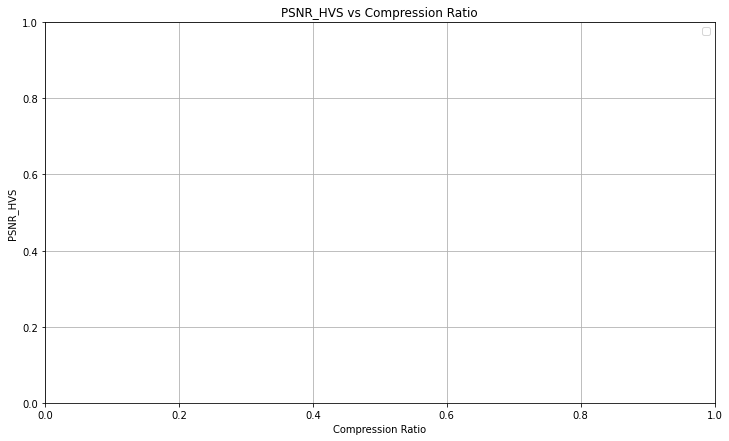

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for JPEG2000 - fsim
No data for SPIHT - fsim
No data for ADCTC - fsim


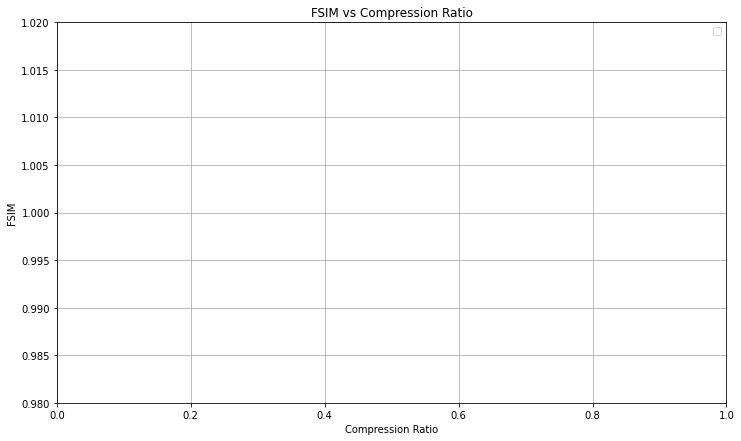

In [30]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # Image paths for comparison (only one image for quick testing)
    image_paths = ["fig1_b.png"]  # Ensure this file exists in the same directory
    # Range of compression ratios for evaluation (fewer points for quick testing)
    cr_values = np.linspace(2, 40, 30) # 5 CR points from 2 to 40
    
    # Define the codecs to compare
    codecs = {
        'JPEG2000': compress_jpeg2000,
        'SPIHT': compress_spiht,
        'ADCTC': compress_adct_actual_with_rate_control 
        # 'ADCTC': lambda img, cr: compress_adct_fixed_qs(img, qs_val=12)

    }
    
    # Structure to store results
    results = {k: {'psnr': [], 'psnr_hvs': [], 'fsim': []} for k in codecs}

    # Main loop for processing each image
    for img_path in image_paths:
        try:
            print(f"Processing {img_path}...")
            image = io.imread(img_path)
            #image = add_realistic_noise(image * 255).astype(np.uint8)
            if image.ndim == 3: 
                image = color.rgb2gray(image) # Convert to grayscale if it's a color image
            image = img_as_float(image) # Convert to float for processing (0-1 range)
            
            for name, func in codecs.items():
                print(f"  Testing {name}...")
                try:
                    p, p_hvs, f = simulate_metrics_for_codec(image, cr_values, func)
                    results[name]['psnr'].append(p)
                    results[name]['psnr_hvs'].append(p_hvs)
                    results[name]['fsim'].append(f)
                except Exception as e:
                    print(f"Error in {name}: {str(e)}")
                    continue # Continue to the next codec if an error occurs
                    
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            continue # Continue to the next image if an error occurs

    # --- Plotting the graphs for each metric ---
    for metric in ['psnr', 'psnr_hvs', 'fsim']:
        plt.figure(figsize=(12,7)) 
        for name in codecs:
            if not results[name][metric]:
                print(f"No data for {name} - {metric}")
                continue
            
            # Calculate the average metric values across all processed images (if multiple)
            # np.nanmean handles potential NaN values from errors during compression
            avg = np.nanmean(results[name][metric], axis=0) 
            plt.plot(cr_values, avg, label=f"{name}", marker='o')
        
        plt.title(f"{metric.upper()} vs Compression Ratio")
        plt.xlabel("Compression Ratio")
        plt.ylabel(metric.upper())
        plt.grid(True)
        plt.legend()
        if metric == 'fsim':
            plt.ylim([0.98, 1.02])  # Appropriate y-axis range for FSIM (typically 0 to 1)
        plt.show()


 Visualizing block partitioning on example image...


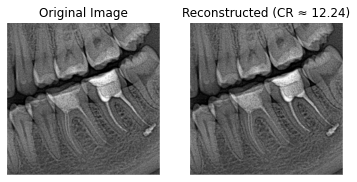

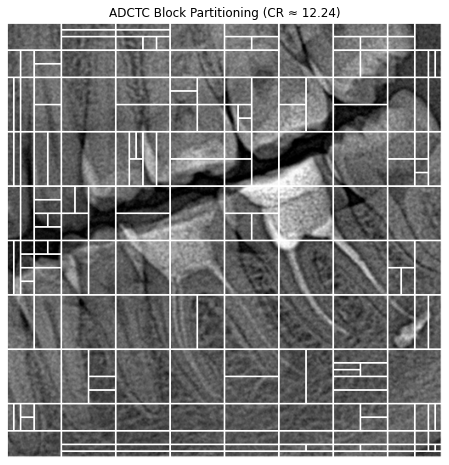

In [29]:
# --- Visualize Block Partitioning for One Image ---
if True:  # ← Set to True to enable or False to disable
    print("\n Visualizing block partitioning on example image...")
    from skimage.io import imread
    from skimage.color import rgb2gray
    from skimage.util import img_as_ubyte

    test_image = imread("sample_image.png")  # Load the test image
    if test_image.ndim == 3:
        test_image = rgb2gray(test_image)  # Convert to grayscale if RGB
    test_image = img_as_ubyte(test_image)  # Convert to uint8 format

    compressor = ADCTCCompressor(QS=12)  # Choose any desired QS value
    recon_img, bits, cr, vis_img = compressor.compress(test_image)

    plt.subplot(1, 2, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Reconstructed (CR ≈ {cr:.2f})")
    plt.axis('off')

    plt.figure(figsize=(10, 8))
    plt.imshow(vis_img, cmap='gray')
    plt.title(f"ADCTC Block Partitioning (CR ≈ {cr:.2f})")
    plt.axis('off')
    plt.show()
